In [ ]:
import matplotlib.pyplot as plt
import random
import os
from skimage.io import imread
from torch.utils.data import DataLoader, random_split
from torch import optim
from os.path import splitext
from os import listdir
import numpy as np
from glob import glob
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

# **Segmentación con U-Net**

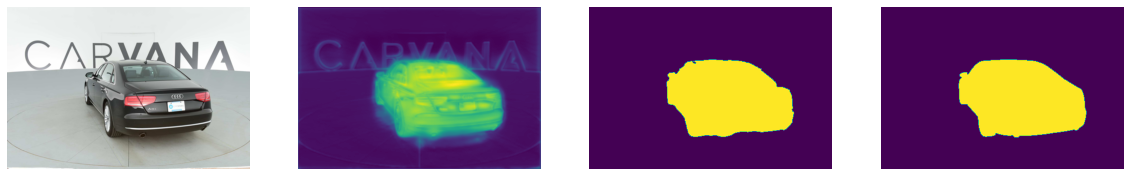

Este `notebook` está basado en el código de https://github.com/milesial/Pytorch-UNet/

### **Obtener Data**

La data proviene de https://www.kaggle.com/c/carvana-image-masking-challenge/data

In [ ]:
#@title Helper

def mostrar(folder, figsize=(15, 9), grid = (4,4)):
  #https://stackoverflow.com/questions/60443761/displaying-random-images-from-multiple-folders-using-python
  images = []
  for image in os.listdir(folder):
    images.append(os.path.join(folder, image))

  plt.figure(1, figsize=figsize)
  plt.axis('off')
  n = 0
  for i in range(grid[0]*grid[1]):
    n += 1
    random_img = random.choice(images)
    imgs = imread(random_img)
    plt.subplot(*grid, n)
    plt.axis('off')
    plt.imshow(imgs)

  plt.show()

In [ ]:
#@title Descargar!
!gdown --id 1D3WT1eT1UXiPTnAoNMN48tbi6nNTIpLH
!gdown --id 1VLDlljyC_4Q0-dLXQmPRSAT2JM4Z7pJ1

### **Descomprimir: Imágenes**

In [ ]:
!unzip -qq train.zip

In [ ]:
mostrar('train')

### **Descomprimir: Máscaras**

In [ ]:
!unzip -qq train_masks.zip

In [ ]:
mostrar('train_masks')

### **Definición de la arquitectura de redes neuronales**

In [ ]:
#@title U-net

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down4 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64 // factor, bilinear)
        self.up4 = Up(64, 32, bilinear)
        self.outc = OutConv(32, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
#@title Dataset

class BasicDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, scale=1, mask_suffix=''):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.scale = scale
        self.mask_suffix = mask_suffix
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'

        self.ids = [splitext(file)[0] for file in listdir(imgs_dir)
                    if not file.startswith('.')]


    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))

        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans

    def __getitem__(self, i):
        idx = self.ids[i]
        mask_file = glob(self.masks_dir + idx + self.mask_suffix + '.*')
        img_file = glob(self.imgs_dir + idx + '.*')

        assert len(mask_file) == 1, \
            f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
        assert len(img_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {img_file}'
        mask = Image.open(mask_file[0])
        img = Image.open(img_file[0])

        assert img.size == mask.size, \
            f'Image and mask {idx} should be the same size, but are {img.size} and {mask.size}'

        img = self.preprocess(img, self.scale)
        mask = self.preprocess(mask, self.scale)

        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.FloatTensor)
        }


In [ ]:
#@title Evaluación
def eval_net(net, loader, device):
    """Evaluation without the densecrf with the dice coefficient"""
    net.eval()
    mask_type = torch.float32 if net.n_classes == 1 else torch.long
    n_val = len(loader)  # the number of batch
    tot = 0


    for batch in loader:
      imgs, true_masks = batch['image'], batch['mask']
      imgs = imgs.to(device=device, dtype=torch.float32)
      true_masks = true_masks.to(device=device, dtype=mask_type)

      with torch.no_grad():
        mask_pred = net(imgs)

      if net.n_classes > 1:
        tot += F.cross_entropy(mask_pred, true_masks).item()
      else:
        pred = torch.sigmoid(mask_pred)
        pred = (pred > 0.5).float()
        tot += dice_coeff(pred, true_masks).item()

    net.train()
    return tot / n_val


class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coeff(input, target):
    """Dice coeff for batches"""
    if input.is_cuda:
        s = torch.FloatTensor(1).cuda().zero_()
    else:
        s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff().forward(c[0], c[1])

    return s / (i + 1)

### **Entrenamiento**

**Parámetros**

In [ ]:
#@title Parámetros
img_scale = 0.25 #@param {type:"slider", min:0.1, max:1, step:0.01}
val_percent = 0.3 #@param {type:"slider", min:0, max:1, step:0.01}
batch_size = 20 #@param {type:"slider", min:0, max:100, step:1}
num_workers = 2 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
lr = 0.001 #@param {type:"number"}
epochs = 3 #@param {type:"slider", min:1, max:100, step:1}
dir_img = 'train/'
dir_mask = 'train_masks/'
device = torch.device('cuda')
criterion = nn.BCEWithLogitsLoss() #si es multiclase, usar nn.CrossEntropyLoss()

**Instanciar objetos**

In [ ]:
dataset = BasicDataset(dir_img, dir_mask, img_scale, mask_suffix='_mask')
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, drop_last=True)
net = UNet(n_channels=3, n_classes=1, bilinear=True)
net.to(device=device)
optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)
global_step = 0

**Loop de entrenamiento**

In [ ]:
for epoch in range(epochs):
  net.train()
  epoch_loss = 0
  for batch in train_loader:
    imgs = batch['image']
    imgs = imgs.to(device=device, dtype=torch.float32)
    mask_type = torch.float32 if net.n_classes == 1 else torch.long
    true_masks = batch['mask']
    true_masks = true_masks.to(device=device, dtype=mask_type)
    masks_pred = net(imgs)
    loss = criterion(masks_pred, true_masks)
    epoch_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_value_(net.parameters(), 0.1)
    optimizer.step()
    global_step += 1
    if global_step % 10 == 0:
      print("Iter {}".format(global_step))
  val_score = eval_net(net, val_loader, device)
  scheduler.step(val_score)
  print("Train Loss {}".format(np.mean(epoch_loss)))
  print("Val Score {}".format(val_score))

In [ ]:
#@title Evaluación { run: "auto" }
i = 165 #@param {type:"slider", min:0, max:1000, step:1}
th = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}
im = val[i]['image']
im_to_show = im.numpy().transpose((1,2,0))
mask_to_show = val[i]['mask'][0]
plt.figure(figsize=(20,8))
plt.subplot(1,4,  1)
plt.axis('off')
plt.imshow(im_to_show)
plt.subplot(1,4,  2)
net.eval()
with torch.no_grad():
  predicted_mask = net(im.unsqueeze(0).to(device)).cpu().numpy()[0, 0]
plt.imshow(predicted_mask)
plt.axis('off')
plt.subplot(1,4,  3)
plt.imshow(predicted_mask>th)
plt.axis('off')
plt.subplot(1,4,  4)
plt.imshow(mask_to_show)
plt.axis('off')
plt.show()

In [ ]:
!nvidia-smi